In [2]:
import os
import glob
import trimesh
import numpy as np
from tensorflow import data as tf_data
from keras import ops
import keras
from keras import layers
from matplotlib import pyplot as plt

keras.utils.set_random_seed(seed=42)


In [3]:
DATA_DIR = "otolithes/sulcus"
mesh = trimesh.load(os.path.join(DATA_DIR, "train/Segmentation_05a-29.ply"))
# mesh.show()


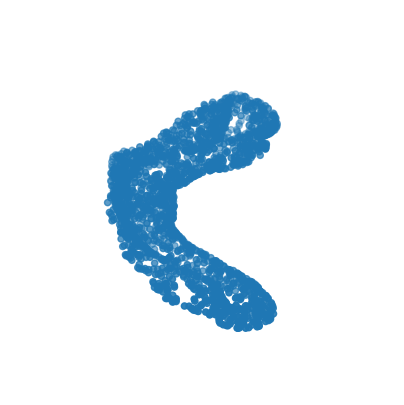

In [4]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()


In [5]:
def parse_dataset(num_points=2048):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
   
    folder = DATA_DIR

    for i, file in enumerate(folder):
        print(f"processing class: {folder}")
        # store folder name with ID so we can retrieve later
       
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(0)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(0)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
     
    )


In [6]:
NUM_POINTS = 2048
NUM_CLASSES = 1
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels = parse_dataset(
    NUM_POINTS
)


processing class: otolithes/sulcus
processing class: otolithes/sulcus
processing class: otolithes/sulcus
processing class: otolithes/sulcus
processing class: otolithes/sulcus
processing class: otolithes/sulcus
processing class: otolithes/sulcus
processing class: otolithes/sulcus
processing class: otolithes/sulcus
processing class: otolithes/sulcus
processing class: otolithes/sulcus
processing class: otolithes/sulcus
processing class: otolithes/sulcus
processing class: otolithes/sulcus
processing class: otolithes/sulcus
processing class: otolithes/sulcus


In [7]:
def parse_dataset(data_class, num_points=2048):
    points = []
    labels = []
    if(data_class == 1):
        DATA_DIR = "sulcus"
    else:
        DATA_DIR = "otolithe"
    
    

    files = glob.glob(os.path.join(DATA_DIR, "*"))
   

    for f in files:
        points.append(trimesh.load(f).sample(num_points))
        labels.append(data_class)

    return np.array(points), np.array(labels)

NUM_POINTS = 2048
NUM_CLASSES = 2
BATCH_SIZE = 32

train_points_sulcus, train_labels_sulcus = parse_dataset(1, NUM_POINTS)
train_points_otolithe, train_labels_otolithe = parse_dataset(0, NUM_POINTS)

train_points = np.concatenate([train_points_sulcus, train_points_otolithe])
train_labels = np.concatenate([train_labels_sulcus, train_labels_otolithe])

In [8]:
def augment(points, label):
    # jitter points
    points += keras.random.uniform(points.shape, -0.005, 0.005, dtype="float64")
    # shuffle points
    points = keras.random.shuffle(points)
    return points, label


train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points)).map(augment)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)


In [9]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [10]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = ops.eye(num_features)

    def __call__(self, x):
        x = ops.reshape(x, (-1, self.num_features, self.num_features))
        xxt = ops.tensordot(x, x, axes=(2, 2))
        xxt = ops.reshape(xxt, (-1, self.num_features, self.num_features))
        return ops.sum(self.l2reg * ops.square(xxt - self.eye))


In [11]:
def tnet(inputs, num_features):
    # Initialise bias as the identity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])


In [12]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()


Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2048, 3)   │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d (Conv1D)     │ (None, 2048, 32)  │     128 │ input_layer[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 2048, 32)  │     128 │ conv1d[0][0]         │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation          │ (None, 2048, 32)  │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 2048, 64)  │   2,112 │ activation[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 2048, 64)  │     256 │ conv1d_1[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_1        │ (None, 2048, 64)  │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2048, 512) │  33,280 │ activation_1[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 2048, 512) │   2,048 │ conv1d_2[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_2        │ (None, 2048, 512) │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ global_max_pooling… │ (None, 512)       │       0 │ activation_2[0][0]   │
│ (GlobalMaxPooling1… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 256)       │ 131,328 │ global_max_pooling1… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 256)       │   1,024 │ dense[0][0]          │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_3        │ (None, 256)       │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │  32,896 │ activation_3[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 128)       │     512 │ dense_1[0][0]        │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_4        │ (None, 128)       │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_2 (Dense)     │ (None, 9)         │   1,161 │ activation_4[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ reshape (Reshape)   │ (None, 3, 3)      │       0 │ dense_2[0][0]      

 Total params: 747,947 (2.85 MB)

 Trainable params: 741,867 (2.83 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [13]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=2, validation_data=validation_dataset)


Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 46.3922 - sparse_categorical_accuracy: 0.5000 - val_loss: 6441.0503 - val_sparse_categorical_accuracy: 0.6000
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step - loss: 50.5760 - sparse_categorical_accuracy: 0.5475 - val_loss: 173.4771 - val_sparse_categorical_accuracy: 0.6000


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


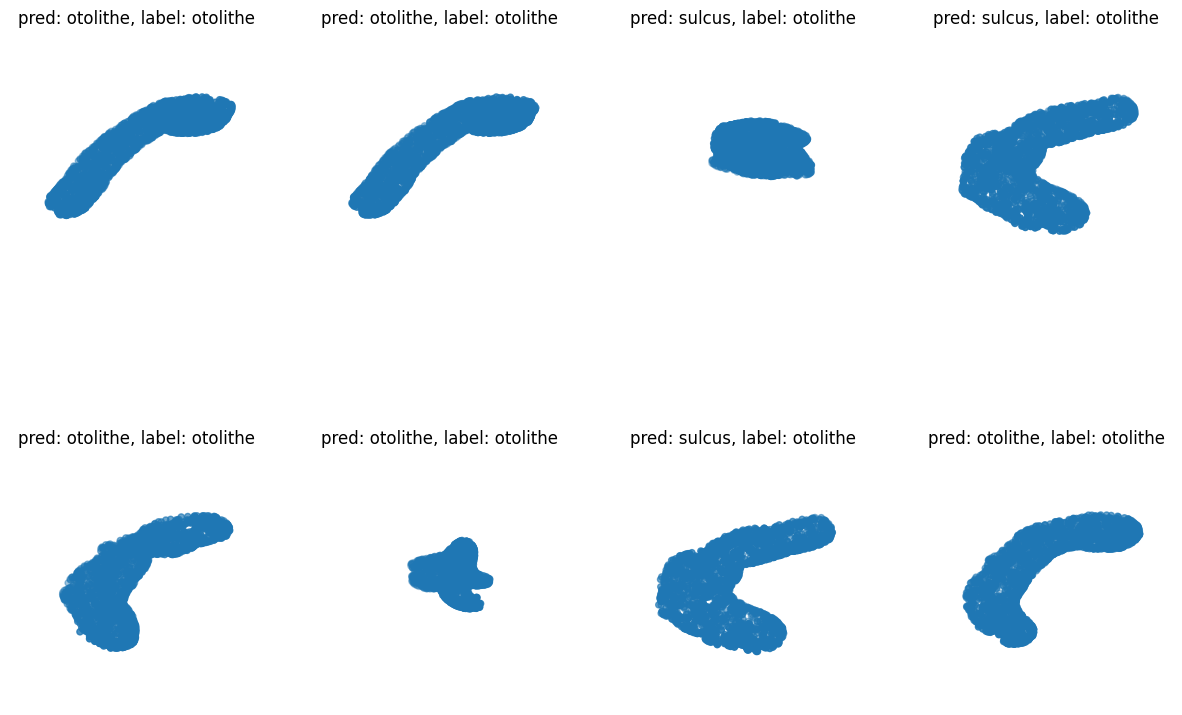

In [14]:
CLASS_MAP = {0:"otolithe", 1: "sulcus"}
# otolithe = trimesh.load("otolithes/otoply/test/Segmentation_05a-31.ply")
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()
